In [32]:
import os
from Utils.read_coord import kml_coord
from Utils.sentinal_request import senti_api

from Utils.sentinal_request_landSat import senti_api as landSat

from Utils.forest_cover import get_cover
from Utils.seques_forecast import plot_SEQ
from datetime import datetime
from dateutil.relativedelta import relativedelta
import glob
from utils import plot_image


In [2]:
file_path = input('Enter kml file path: ')
print(file_path)
#C:\Users\Harith\EngenuityAI\SPE\SPE-development\sentinal\gAMPOLA TEST SITE 2.kml
if os.path.exists(file_path):
    print('The file exists')

    with open(file_path, 'r', encoding='utf-8-sig') as f:
        lines = f.readlines()

        #print(lines)
else:
    print('The specified file does NOT exist')

Enter kml file path: C:\Users\Harith\EngenuityAI\SPE\SPE-development\sentinal\gAMPOLA TEST SITE 2.kml
C:\Users\Harith\EngenuityAI\SPE\SPE-development\sentinal\gAMPOLA TEST SITE 2.kml
The file exists


In [3]:
# getting polygon coordinates
poly_coord = kml_coord(file_path)

In [4]:
img_senti,resol = senti_api(poly_coord)

In [75]:
from sentinelhub import (
    CRS,
    BBox,
    Geometry,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)
import numpy as np
import pandas as pd

In [12]:
def bbox_cord(poly):
    poly_arr = np.array(poly)
    df = pd.DataFrame(poly_arr, columns = ['lat','long'])
    Xmin = df['lat'].min()
    Ymin = df['long'].min()
    Xmax = df['lat'].max()
    Ymax = df['long'].max()
    bbox = [Xmin,Ymin,Xmax,Ymax]
    return bbox

In [13]:
bbox_generated = bbox_cord(poly_coord)
bbox_generated

[80.54821585722028, 7.090095618354233, 80.55549105606482, 7.094269353814045]

In [38]:
final_bbox = BBox(bbox=bbox_generated, crs=CRS.WGS84)
geometry = Geometry(geometry={"type":"Polygon","coordinates":[poly_coord]}, crs=CRS.WGS84)

resolution =15
box_size = bbox_to_dimensions(final_bbox, resolution= resolution)
print(f"Image shape at {resolution} m resolution: {box_size} pixels")

#date range
current_date = datetime.today().strftime('%Y-%m-%d')
past_date = datetime.today() - relativedelta(months=12)
past_date = past_date.strftime('%Y-%m-%d')



Image shape at 15 m resolution: (54, 31) pixels


In [123]:
from sentinelhub import SHConfig
config = SHConfig()
evalscript_all_bands = """
    //VERSION=3
    function setup() {
  return {
    input: ["B05","B02", "B03", "B04"],
    output: { bands: 4 }
  };
}

    function evaluatePixel(sample) {
        return [sample.B05,
                sample.B02,
                sample.B03,
                sample.B04,
];
    }
"""
#32 bit Tiff output wuth 4 bands
request_all_bands = SentinelHubRequest(
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.LANDSAT_OT_L1,          
            time_interval=('2022-08-01', '2022-10-26'),
            mosaicking_order=MosaickingOrder.LEAST_CC,
            other_args={"dataFilter": {"maxCloudCoverage": 20}},
        ),
    ],
        responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
    bbox=final_bbox,
    size=box_size,
    geometry = geometry,
    config=config,
)

In [124]:
print(past_date,current_date)

2021-10-26 2022-10-26


In [125]:
#API request
all_bands_response = request_all_bands.get_data()

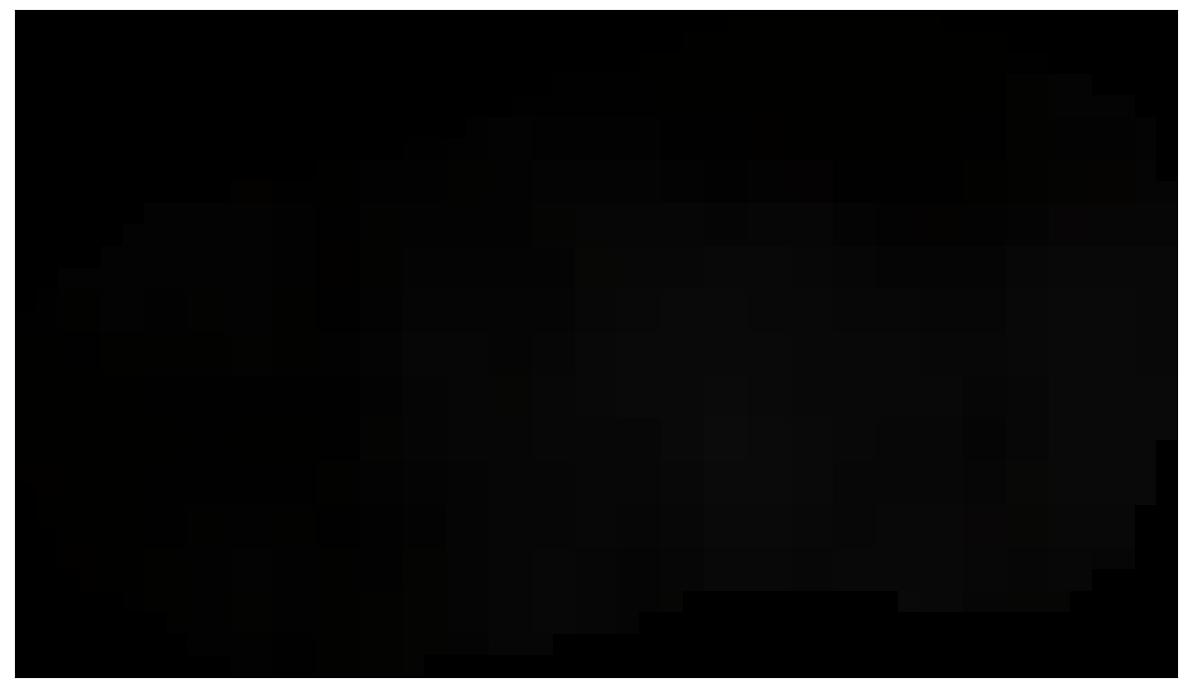

In [126]:
#visualize RGB
plot_image(all_bands_response[0][:, :, [1, 2, 3]], factor=3.5 / 1e4, clip_range=(0, 1))

In [129]:
forest_area,forest_cover,green_pixel,green_cov,ndvi = get_cover(all_bands_response[0][:, :, [0, 1, 2,3]],resol)

In [128]:
all_bands_response

[array([[[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]], dtype=uint8)]

# for PNG


In [90]:
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, BBox, SHConfig, Geometry


evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B02", "B03", "B04","B05"],
    output: { bands: 4 }
  };
}

function evaluatePixel(sample) {
  return [2.5 * sample.B05, 2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
}
"""
bbox = BBox(bbox=[80.549688, 7.289936, 80.587803, 7.313604], crs=CRS.WGS84)

request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.LANDSAT_OT_L1,          
            time_interval=('2022-08-01', '2022-10-26'),          
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
    bbox=bbox,
    size=[512, 320.52399999999994],
    config=config
)

response = request.get_data()


Image type: uint8


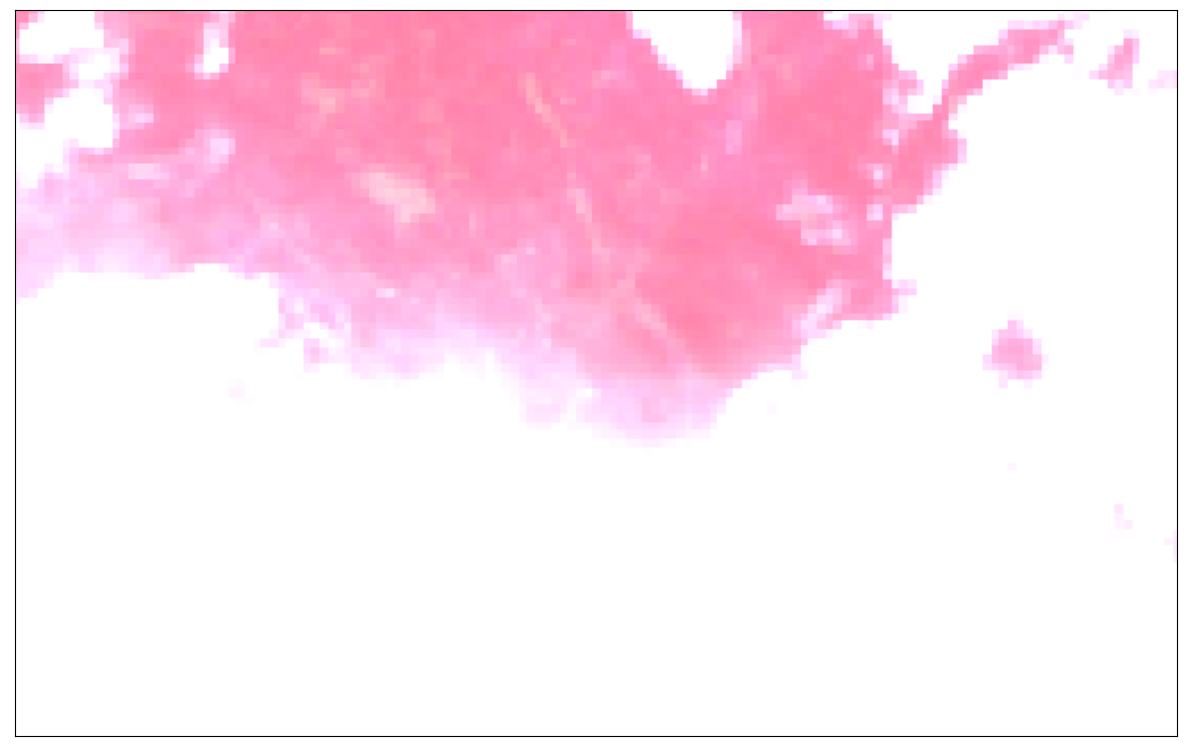

In [91]:
image = response[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

In [92]:
response

[array([[[101,  39,  51,  67],
         [101,  39,  51,  67],
         [ 94,  38,  50,  69],
         ...,
         [235, 176, 178, 196],
         [255, 200, 199, 214],
         [255, 200, 199, 214]],
 
        [[101,  39,  51,  67],
         [101,  39,  51,  67],
         [ 94,  38,  50,  69],
         ...,
         [235, 176, 178, 196],
         [255, 200, 199, 214],
         [255, 200, 199, 214]],
 
        [[ 93,  38,  51,  67],
         [ 93,  38,  51,  67],
         [103,  42,  53,  74],
         ...,
         [248, 189, 190, 206],
         [255, 207, 205, 221],
         [255, 207, 205, 221]],
 
        ...,
 
        [[242, 164, 170, 192],
         [242, 164, 170, 192],
         [242, 164, 170, 192],
         ...,
         [255, 188, 192, 204],
         [255, 206, 209, 216],
         [255, 206, 209, 216]],
 
        [[255, 181, 186, 207],
         [255, 181, 186, 207],
         [255, 181, 186, 207],
         ...,
         [255, 188, 192, 204],
         [255, 206, 209, 216],
    